In [1]:
import numpy as np
import pandas as pd
import torch
from gcn_model import GCNModel
import utilities
from test_model import test_model
import os

In [2]:
#data_folder = "/home/groups/ConradLab/daniel/sharp_sims/splat_0.7_de_rq/"
data_folder = "simulations/splat_0.7_de_rq/"

In [3]:
os.path.exists(data_folder + "preds.csv")

True

In [3]:
# get labels
data_path = data_folder + "query_counts.csv"
tools = ["sctype","scsorter","scina","singler", "scpred"]
#tools = ["scsorter","scina","singler"]
ref_path = data_folder + "ref_counts.csv"
ref_label_path = data_folder + "ref_labels.csv"
marker_path = data_folder + "markers.txt"
if os.path.exists(data_folder + "preds.csv"):
    all_labels = pd.read_csv(data_folder + "preds.csv", index_col=0)
    if all_labels.shape[1] != len(tools): 
        all_labels = all_labels[tools]
        #raise Exception("wrong amount of tools in file")
else:
    all_labels = utilities.label_counts(data_path,tools,ref_path,ref_label_path,marker_path)

In [13]:
all_labels = utilities.label_counts(data_path,tools,ref_path,ref_label_path,marker_path)

R[write to console]: Loading required package: Seurat




    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

R[write to console]: Attaching SeuratObject

R[write to console]: Attaching sp

R[write to console]: Loading required package: SCINA

R[write to console]: Loading required package: MASS

R[write to console]: Loading required package: gplots

R[write to console]: 
Attaching package: ‘gplots’


R[write to console]: The following object is masked from ‘package:stats’:

    lowess


R[write to console]: Loading required package: scSorter

R[write to console]: Loading required package: dplyr

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following object is masked from ‘package:MASS’:

    select


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: SingleR

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading re

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1000
Number of edges: 39615

Running Louvain algorithm...


R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: 

Maximum modularity in 10 random starts: 0.5875
Number of communities: 4
Elapsed time: 0 seconds


R[write to console]: Performing log-normalization

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to conso

●  Extracting feature space for each cell type...
  |                                                  | 0 % ~calculating   |+++++++++++++                                     | 25% ~00s           |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++++++++++++            | 75% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  
DONE!
●  Training models for each cell type...
  |                                                  | 0 % ~calculating  

R[write to console]: Loading required package: ggplot2

R[write to console]: Loading required package: lattice



  |+++++++++++++                                     | 25% ~17s           |+++++++++++++++++++++++++                         | 50% ~10s           |++++++++++++++++++++++++++++++++++++++            | 75% ~05s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=18s  
DONE!
●  Matching reference with new dataset...
	 ─ 2000 features present in reference loadings
	 ─ 2000 features shared between reference and new dataset
	 ─ 100% of features in the reference are present in new dataset
●  Aligning new data to reference...


R[write to console]: Harmony 1/20

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write t

●  Classifying cells...
DONE!


In [43]:
all_labels.shape[1]

3

In [4]:
all_labels

,scina,scsorter,sctype,singler,scpred
Cell1001,Group2,Group2,Group1,Group2,Group2
Cell1002,Group4,Group2,Group1,Group4,Group2
Cell1003,Group1,Group4,Group1,Group2,NaN
Cell1004,Group4,Group4,Group4,Group4,Group1
Cell1005,Group1,Group1,Group1,Group1,Group1
...,...,...,...,...,...
Cell1996,Group2,Group2,Group4,Group2,Group1
Cell1997,Group1,Group1,Group1,Group1,Group1
Cell1998,Group3,Group3,Group4,Group3,Group3
Cell1999,Group4,Group4,Group1,Group4,NaN


In [7]:
# read in dataset
X = pd.read_csv(data_path, index_col=0)
X, keep_cells = utilities.preprocess(np.array(X), scale=False)
X.shape

(999, 500)

In [15]:
all_labels = all_labels.loc[keep_cells,:]

In [9]:
_,marker_names = utilities.read_marker_file(marker_path)
marker_names

['Group1', 'Group2', 'Group3', 'Group4']

In [10]:
all_labels['scsorter']

Cell1001    Group2
Cell1002    Group2
Cell1003    Group4
Cell1004    Group4
Cell1005    Group1
             ...  
Cell1996    Group2
Cell1997    Group1
Cell1998    Group3
Cell1999    Group4
Cell2000    Group2
Name: scsorter, Length: 999, dtype: object

In [16]:
all_labels_factored = utilities.factorize_df(all_labels, marker_names)
encoded_labels = utilities.encode_predictions(all_labels_factored)
encoded_labels

array([[0., 5., 0., 0.],
       [0., 3., 0., 2.],
       [1., 2., 0., 1.],
       ...,
       [0., 0., 5., 0.],
       [0., 1., 0., 3.],
       [0., 4., 0., 1.]])

In [11]:
meta_path = data_folder + "query_meta.csv"
metadata = pd.read_csv(meta_path, index_col=0)
real_y = pd.factorize(metadata['Group'], sort=True)[0]
real_y = real_y[keep_cells]
real_y.shape

(999,)

In [61]:
len(real_y[real_y==0])

245

In [17]:
print(utilities.pred_accuracy(all_labels_factored['scina'], real_y))
print(utilities.pred_accuracy(all_labels_factored['sctype'], real_y))
print(utilities.pred_accuracy(all_labels_factored['scsorter'], real_y))
print(utilities.pred_accuracy(all_labels_factored['singler'], real_y))
print(utilities.pred_accuracy(all_labels_factored['scpred'], real_y))


0.792792797088623
0.8138138055801392
0.826826810836792
0.8408408164978027
0.6026026010513306


In [23]:
max_pred = torch.tensor(encoded_labels).max(dim=1)[1]
utilities.pred_accuracy(max_pred, real_y)

0.9389389157295227

In [24]:
confident_labels = utilities.get_consensus_labels(encoded_labels, necessary_vote = 3)
confident_labels.shape

(999,)

In [25]:
train_nodes = np.where(confident_labels != -1)[0]
test_nodes = np.where(confident_labels == -1)[0]
print(np.unique(confident_labels))
print(np.unique(confident_labels[train_nodes]))
print(np.unique(confident_labels[test_nodes]))

[-1.  0.  1.  2.  3.]
[0. 1. 2. 3.]
[-1.]


In [26]:
real_y[test_nodes]

array([3, 0, 3, 0, 0, 0, 1, 2, 2, 2, 3, 0, 1, 1, 3, 2, 0, 1, 2, 3, 2, 1,
       0, 3, 3, 0, 3, 1, 2, 1, 1, 0, 0, 3, 2, 0, 0, 1, 2, 2, 0, 1, 1, 3,
       2, 0, 0, 0, 0, 3, 3, 3, 0, 3, 1, 0, 3, 3, 0, 1, 2, 2, 0, 2, 1, 0,
       3, 1, 0, 0, 2, 1, 3, 2, 0, 0, 0, 0, 2, 1, 0, 0, 2, 3, 0, 2, 3, 0,
       1, 2, 3, 2, 2, 2, 2, 0, 3, 0, 2, 3, 3, 2, 2, 0, 0, 2, 2, 0, 0, 0,
       3, 1, 2, 2, 0, 0, 2, 0])

In [27]:
print(utilities.pred_accuracy(confident_labels[train_nodes], real_y[train_nodes]))

0.9807037711143494


In [28]:
len(test_nodes)

118

In [21]:
# tool accuracy on test
print(utilities.pred_accuracy(np.array(all_labels_factored['scina'][test_nodes]), real_y[test_nodes]))
print(utilities.pred_accuracy(np.array(all_labels_factored['sctype'][test_nodes]), real_y[test_nodes]))
print(utilities.pred_accuracy(np.array(all_labels_factored['scsorter'][test_nodes]), real_y[test_nodes]))
print(utilities.pred_accuracy(np.array(all_labels_factored['singler'][test_nodes]), real_y[test_nodes]))
print(utilities.pred_accuracy(np.array(all_labels_factored['scpred'][test_nodes]), real_y[test_nodes]))
max_pred = torch.tensor(encoded_labels).max(dim=1)[1]
print(utilities.pred_accuracy(max_pred[test_nodes], real_y[test_nodes]))

0.19491524994373322
0.3644067943096161
0.43220338225364685
0.5932203531265259
0.17796610295772552
0.6271186470985413


In [29]:
dataset  = torch.utils.data.TensorDataset(torch.tensor(X), torch.tensor(confident_labels))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=35, shuffle=True)

test_dataset  = torch.utils.data.TensorDataset(torch.tensor(X), torch.tensor(real_y))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=35, shuffle=False)

In [30]:
m = GCNModel("configs/2_8.txt", 2, dropout=0.0)

In [31]:
m.train(dataloader, 100)

Loss in epoch 0 = 36.780918
Loss in epoch 10 = 0.142983
Loss in epoch 20 = 0.038523
Loss in epoch 30 = 0.018872
Loss in epoch 40 = 0.008604
Loss in epoch 50 = 0.006198
Loss in epoch 60 = 0.003754
Loss in epoch 70 = 0.002780
Loss in epoch 80 = 0.002784
Loss in epoch 90 = 0.001744


In [32]:
m.validation_metrics(test_dataloader, train_nodes, test_nodes)

(0.9699699878692627,
 array([[222,   4,   1,   5],
        [  0, 267,   1,   0],
        [  2,   4, 223,   5],
        [  2,   5,   1, 257]]),
 0.9807037711143494,
 array([[183,   3,   1,   3],
        [  0, 249,   0,   0],
        [  1,   2, 195,   4],
        [  1,   1,   1, 237]]),
 0.8898305296897888,
 array([[39,  1,  0,  2],
        [ 0, 18,  1,  0],
        [ 1,  2, 28,  1],
        [ 1,  4,  0, 20]]))

In [61]:
data_folders = ["/home/groups/ConradLab/daniel/sharp_sims/splat_0.6_de_rq/", "/home/groups/ConradLab/daniel/sharp_sims/splat_0.7_de_rq/", "/home/groups/ConradLab/daniel/sharp_sims/splat_0.8_de_rq/"]
#data_folders = ["simulations/splat_0.6_de_rq/", "simulations/splat_0.7_de_rq/", "simulations/splat_0.8_de_rq/"]
tools = ["sctype","scsorter","scina","singler", "scpred"]
votes_necessary = 3
model_file = "configs/3_8.txt"
neighbors = 2
batch_size=35
training_epochs=200
random_inits = 5

In [62]:
results = test_model(data_folders, tools, votes_necessary, model_file, neighbors, batch_size, training_epochs, random_inits)

[0.8479999899864197, 0.8109999895095825, 0.8550000190734863, 0.8230000138282776, 0.859000027179718]


/home/users/lewinsda/scSHARP/utilities.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return float((torch.tensor(preds) == torch.tensor(real)).type(torch.FloatTensor).mean().numpy())


[0.9649649858474731, 0.9689689874649048, 0.9569569826126099, 0.9649649858474731, 0.9629629850387573]


/home/users/lewinsda/scSHARP/utilities.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return float((torch.tensor(preds) == torch.tensor(real)).type(torch.FloatTensor).mean().numpy())


[0.9869869947433472, 0.9879879951477051, 0.9869869947433472, 0.9879879951477051, 0.9869869947433472]


/home/users/lewinsda/scSHARP/utilities.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return float((torch.tensor(preds) == torch.tensor(real)).type(torch.FloatTensor).mean().numpy())


In [63]:
results

,data_name,method,total_accuracy,train_accuracy,test_accuracy,total_sd,train_sd,test_sd
0,splat_0.6_de_rq,GCN,0.839200,0.944708,0.657221,0.021076,0.0,0.057428
1,splat_0.6_de_rq,Max Col.,0.798000,0.944708,0.544959,0.000000,0.0,0.000000
2,splat_0.6_de_rq,Confident Labels,NaN,0.944708,NaN,0.000000,0.0,0.000000
3,splat_0.6_de_rq,sctype,0.232000,0.235387,0.226158,0.000000,0.0,0.000000
4,splat_0.6_de_rq,scsorter,0.677000,0.846761,0.384196,0.000000,0.0,0.000000
5,splat_0.6_de_rq,scina,0.467000,0.668246,0.119891,0.000000,0.0,0.000000
6,splat_0.6_de_rq,singler,0.840000,0.913112,0.713896,0.000000,0.0,0.000000
7,splat_0.6_de_rq,scpred,0.503000,0.663507,0.226158,0.000000,0.0,0.000000
0,splat_0.7_de_rq,GCN,0.963764,0.980704,0.837288,0.004386,0.0,0.037134
1,splat_0.7_de_rq,Max Col.,0.938939,0.980704,0.627119,0.000000,0.0,0.000000


In [9]:
# check grid search results
grid_results = pd.read_csv("grid_search_0.5_output/combined.csv", header=None, index_col=0)
grid_results.columns = ["Total Accuracy", "Train Accuracy", "Test Accuracy"]

In [10]:
grid_results.sort_values("Test Accuracy", ascending=False).head(50)

,Total Accuracy,Train Accuracy,Test Accuracy
0,,,
2345,0.846,0.976492,0.684564
1996,0.839,0.976492,0.668904
1801,0.839,0.976492,0.668904
1621,0.838,0.976492,0.666667
1269,0.837,0.976492,0.664430
1103,0.835,0.976492,0.659955
1261,0.835,0.976492,0.659955
721,0.834,0.976492,0.657718
901,0.833,0.976492,0.655481


In [52]:
grid_results = pd.read_csv("grid_search_0.7_output/combined.csv", header=None, index_col=0)
grid_results.columns = ["Total Accuracy", "Train Accuracy", "Test Accuracy", "Config", "Dropout", "Batch", "Neighbors"]

In [53]:
# add layer and embedding columns
#grid_results['Config'].apply(str.split("_"))
grid_results['GCN Layers'] = grid_results['Config'].apply(lambda x: x.split('_')[0])
grid_results['Final Embedding'] = grid_results['Config'].apply(lambda x: x.split('_')[1].split(".")[0])

In [54]:
grid_results.sort_values("Test Accuracy", ascending=False).head(50)

,Total Accuracy,Train Accuracy,Test Accuracy,Config,Dropout,Batch,Neighbors,GCN Layers,Final Embedding
0,,,,,,,,,
5,0.974975,0.980704,0.932203,3_8.txt,0.0,35,2,3,8
1981,0.973974,0.980704,0.923729,3_25.txt,0.0,20,2,3,25
181,0.973974,0.980704,0.923729,2_25.txt,0.0,20,2,2,25
211,0.972973,0.980704,0.915254,2_25.txt,0.0,95,5,2,25
1625,0.972973,0.980704,0.915254,2_15.txt,0.0,35,2,2,15
541,0.972973,0.980704,0.915254,2_8.txt,0.0,20,2,2,8
743,0.971972,0.980704,0.906780,3_60.txt,0.0,80,2,3,60
24,0.970971,0.980704,0.898305,3_8.txt,0.0,80,5,3,8
1990,0.970971,0.980704,0.898305,3_25.txt,0.0,50,2,3,25


<AxesSubplot:xlabel='Dropout', ylabel='Test Accuracy'>

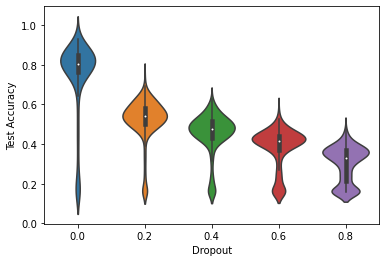

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.violinplot(x=grid_results["Dropout"], y=grid_results["Test Accuracy"])

In [56]:
grid_results = grid_results[grid_results['Dropout'] == 0.0]

<AxesSubplot:xlabel='Neighbors', ylabel='Test Accuracy'>

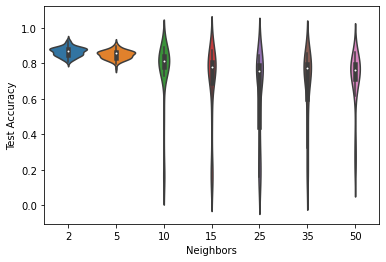

In [57]:
sns.violinplot(x=grid_results["Neighbors"], y=grid_results["Test Accuracy"])

<AxesSubplot:xlabel='Batch', ylabel='Test Accuracy'>

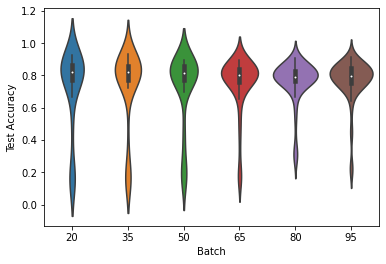

In [58]:
sns.violinplot(x=grid_results["Batch"], y=grid_results["Test Accuracy"])

<AxesSubplot:xlabel='GCN Layers', ylabel='Test Accuracy'>

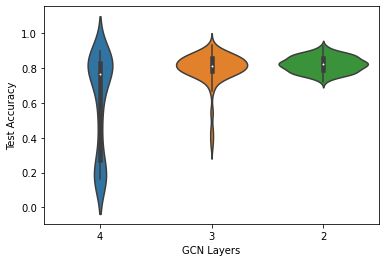

In [59]:
sns.violinplot(x=grid_results["GCN Layers"], y=grid_results["Test Accuracy"])

<AxesSubplot:xlabel='Final Embedding', ylabel='Test Accuracy'>

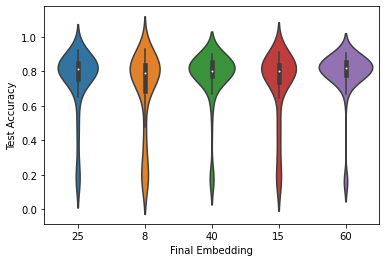

In [60]:
sns.violinplot(x=grid_results["Final Embedding"], y=grid_results["Test Accuracy"])